<a href="https://colab.research.google.com/github/MuayThaiLegz/PracticeCrazy/blob/main/TensorTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math, random, json
from datetime import datetime, timedelta

import pandas as pd
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
#from dmba import regressionSummary

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')


import random
import json
from datetime import datetime, timedelta


from scipy.interpolate import make_interp_spline
#from bson import ObjectId
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from statsmodels.tsa.arima.model import ARIMA
import joblib
import os
import math
import random
import json
RANDOM_SEED = np.random.seed(0)
from datetime import datetime, timedelta


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input

RANDOM_SEED = np.random.seed(0)
import tensorflow as tf


In [2]:
# |zip_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#     fname='jena_climate_2009_2016.csv.zip',
#     extract=True)
# csv_path, _ = os.path.splitext(zip_path)

In [3]:

# Slice [start:stop:step], starting from index 5 take every 6th record.


In [4]:
solo = ["payload.publishedAt","BatV","Hum_SHT","TempC_DS",'TempC_SHT']


df = pd.read_csv('AnomaliesCompdf.csv')[solo]

df = df[5::6]

date_time = pd.to_datetime(df.pop('payload.publishedAt'), format='%Y-%m-%d %H:%M:%S.%f')


In [5]:
# plot_cols = solo[1:]
# plot_features = df[plot_cols]
# plot_features.index = date_time
# _ = plot_features.plot(subplots=True)

# plot_features = df[plot_cols][:120]
# plot_features.index = date_time[:120]
# _ = plot_features.plot(subplots=True)

In [6]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)


In [7]:
df

,BatV,Hum_SHT,TempC_DS,TempC_SHT
5,-1.286044,-1.622945,0.204523,0.964920
11,-0.367203,-1.594294,-0.557170,0.676619
17,-1.352148,0.096107,0.897362,1.493832
23,-0.251522,0.029255,0.641313,0.726475
29,-0.753910,-0.973526,-0.387187,-1.053185
...,...,...,...,...
5441,-1.447998,-1.331661,0.159338,-1.638457
5447,-0.162282,-0.691792,0.146428,0.514043
5453,0.733423,-0.849372,-0.740062,-1.408683
5459,-0.753910,-1.560868,-0.643237,0.544391


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [9]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


def plot(self, model=None, plot_col='TempC_DS', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [11]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['TempC_DS'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['TempC_DS']

In [12]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['TempC_DS'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['TempC_DS']

In [ ]:
val_performance = {}
performance = {}

In [16]:
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

Multi-step dense
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time

The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of three-hour inputs and one-hour labels:

Note that the Window's shift parameter is relative to the end of the two windows.

In [20]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['TempC_DS'])


multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)
model = multi_step_dense
MAX_EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

window = conv_window

history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.val)
                    #callbacks=[early_stopping])

# val_performance[f'model.name'] = model.evaluate(window.val)
# performance[f'model.name'] = model.evaluate(window.test, verbose=0)
# conv_window.plot(multi_step_dense)

Input shape: (32, 3, 4)
Output shape: (32, 1, 1)
Epoch 1/50
20/20 [==============================] - 1s 16ms/step - loss: 1.1143 - mean_absolute_error: 0.8478 - val_loss: 1.0341 - val_mean_absolute_error: 0.8739
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 1.0251 - mean_absolute_error: 0.8393 - val_loss: 1.0073 - val_mean_absolute_error: 0.8593
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.9830 - mean_absolute_error: 0.8242 - val_loss: 0.9927 - val_mean_absolute_error: 0.8468
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.9584 - mean_absolute_error: 0.8149 - val_loss: 0.9867 - val_mean_absolute_error: 0.8462
Epoch 5/50
20/20 [==============================] - 0s 11ms/step - loss: 0.9452 - mean_absolute_error: 0.8118 - val_loss: 0.9868 - val_mean_absolute_error: 0.8459
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.9248 - mean_absolute_error: 0.8036 - val_loss: 0.9801 - val_mean_

In [39]:


model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
MAX_EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['TempC_DS'])


history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.val)

val_performance[f'{model.name}'] = model.evaluate(window.val)
performance[f'{model.name}'] = model.evaluate(window.test, verbose=0)

TypeError: ignored

In [24]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['TempC_DS'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['TempC_DS']

In [25]:
window = wide_conv_window

history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.val)

val_performance[f'{model.name}'] = model.evaluate(window.val)
performance[f'{model.name}'] = model.evaluate(window.test, verbose=0)

Epoch 1/50
20/20 [==============================] - 3s 43ms/step - loss: 0.5108 - mean_absolute_error: 0.5709 - val_loss: 1.1783 - val_mean_absolute_error: 0.8815
Epoch 2/50
20/20 [==============================] - 0s 20ms/step - loss: 0.5015 - mean_absolute_error: 0.5651 - val_loss: 1.1804 - val_mean_absolute_error: 0.8830
Epoch 3/50
20/20 [==============================] - 1s 20ms/step - loss: 0.4933 - mean_absolute_error: 0.5600 - val_loss: 1.1875 - val_mean_absolute_error: 0.8853
Epoch 4/50
20/20 [==============================] - 1s 21ms/step - loss: 0.4846 - mean_absolute_error: 0.5545 - val_loss: 1.1914 - val_mean_absolute_error: 0.8871
Epoch 5/50
20/20 [==============================] - 0s 19ms/step - loss: 0.4766 - mean_absolute_error: 0.5488 - val_loss: 1.1934 - val_mean_absolute_error: 0.8883
Epoch 6/50
20/20 [==============================] - 0s 16ms/step - loss: 0.4681 - mean_absolute_error: 0.5424 - val_loss: 1.1998 - val_mean_absolute_error: 0.8911
Epoch 7/50
20/20 [====

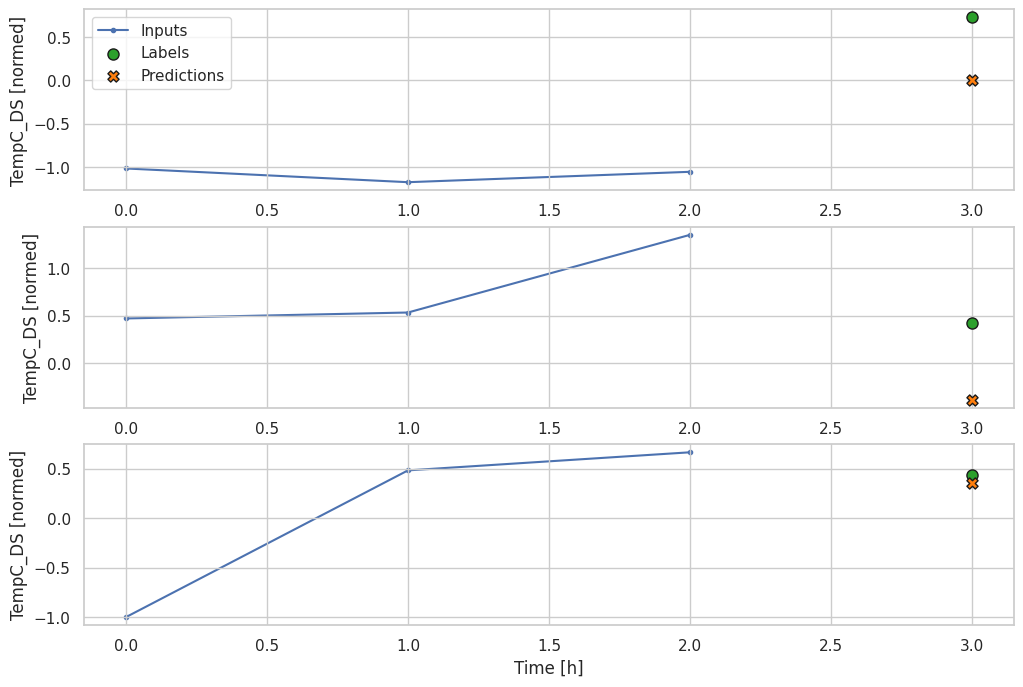

In [38]:
wide_conv_window.plot(multi_step_dense)

In [27]:
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['TempC_DS'])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

model = lstm_model
MAX_EPOCHS = 50

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   patience=patience,
#                                                   mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# window = WindowGenerator(
#     input_width=24, label_width=24, shift=1,
#     label_columns=['TempC_DS'])


history = model.fit(wide_conv_window.train, epochs=MAX_EPOCHS,
                    validation_data=wide_conv_window.val)

val_performance[f'{model.name}'] = model.evaluate(wide_conv_window.val)
performance[f'{model.name}'] = model.evaluate(wide_conv_window.test, verbose=0)


Epoch 1/50
20/20 [==============================] - 6s 61ms/step - loss: 1.0092 - mean_absolute_error: 0.8424 - val_loss: 0.9891 - val_mean_absolute_error: 0.8442
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 1.0032 - mean_absolute_error: 0.8409 - val_loss: 0.9861 - val_mean_absolute_error: 0.8415
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 1.0002 - mean_absolute_error: 0.8399 - val_loss: 0.9838 - val_mean_absolute_error: 0.8392
Epoch 4/50
20/20 [==============================] - 0s 11ms/step - loss: 0.9991 - mean_absolute_error: 0.8393 - val_loss: 0.9834 - val_mean_absolute_error: 0.8386
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.9976 - mean_absolute_error: 0.8385 - val_loss: 0.9829 - val_mean_absolute_error: 0.8383
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.9958 - mean_absolute_error: 0.8378 - val_loss: 0.9816 - val_mean_absolute_error: 0.8382
Epoch 7/50
20/20 [=====

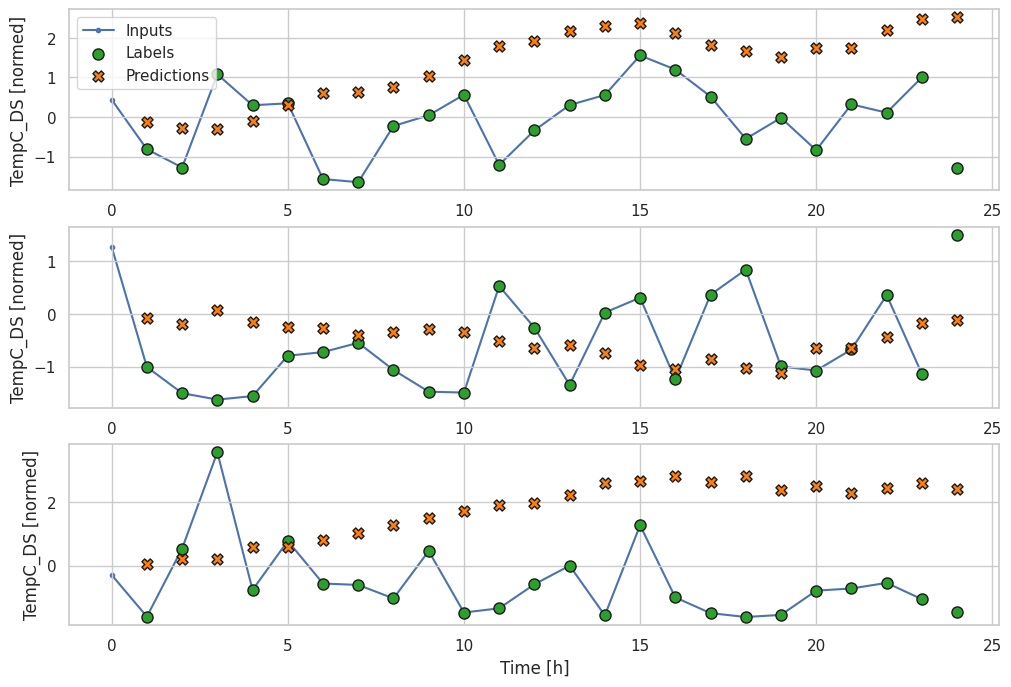

In [28]:
wide_window.plot(lstm_model)

In [29]:
window = conv_window

history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.val)
                    #callbacks=[early_stopping])

val_performance[f'{model.name}'] = model.evaluate(window.val)
performance[f'{model.name}'] = model.evaluate(window.test, verbose=0)

Epoch 1/50
20/20 [==============================] - 1s 57ms/step - loss: 0.9462 - mean_absolute_error: 0.8090 - val_loss: 0.9809 - val_mean_absolute_error: 0.8306
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 0.9448 - mean_absolute_error: 0.8083 - val_loss: 0.9785 - val_mean_absolute_error: 0.8286
Epoch 3/50
20/20 [==============================] - 1s 24ms/step - loss: 0.9448 - mean_absolute_error: 0.8091 - val_loss: 0.9797 - val_mean_absolute_error: 0.8293
Epoch 4/50
20/20 [==============================] - 0s 11ms/step - loss: 0.9429 - mean_absolute_error: 0.8077 - val_loss: 0.9789 - val_mean_absolute_error: 0.8281
Epoch 5/50
20/20 [==============================] - 0s 10ms/step - loss: 0.9432 - mean_absolute_error: 0.8075 - val_loss: 0.9795 - val_mean_absolute_error: 0.8306
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - loss: 0.9417 - mean_absolute_error: 0.8067 - val_loss: 0.9779 - val_mean_absolute_error: 0.8275
Epoch 7/50
20/20 [====

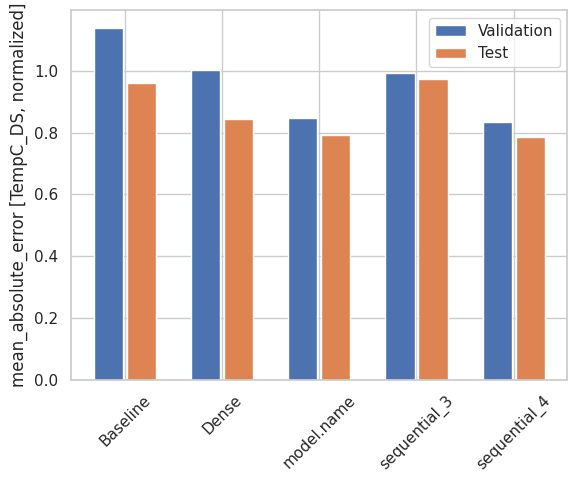

In [30]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [TempC_DS, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
df_std